<h2>Particle Image Velocimetry using OpenPIV</h2>
<br>by: Prof. Daniel Borrero, Department of Physics, Willamette University

This notebook will walk you through the process of carrying out a simple measurement of the velocity field of a fluid using particle image velocimetry (PIV) using the OpenPIV software library. It is a more detailed walkthrough of the tutorial in the OpenPIV documentation.


<h3>Installing OpenPIV</h3>

This document assumes that you have already installed the Anaconda Python distribution. If this is not the case, you can download and install Anaconda <a href="https://www.anaconda.com/products/individual">here</a>. To install OpenPIV, open the Anaconda prompt (you may have to run it with administrator priviledges for the installation to work correctly, type

`conda install -c conda-forge openpiv`,

and hit `Enter`. The <tt>conda</tt> package manager will analyze your system and determine which packages need to be installed or upgraded so that OpenPIV can run. When asked whether you want to proceed, type `y` and hit `Enter`. Once the installer is done running, you should be good to go.

It will also be useful to install OpenCV, a machine vision/image processing package. To install this, type

`conda install -c conda-forge opencv`

into your Anaconda terminal and hit `Enter`. When prompted if you want to proceed, say yes.

If you haven't updated your installation of Anaconda in a while, this is also a good opportunity to do so. Type

`conda update --all`

and hit `Enter` to bring all your packages up to date. When prompted if you want to proceed, say yes. After all the updates are completed, you'll want to restart Jupyter notebook to make sure that it is using the latest packages.

Note: This notebook was written and tested using `numpy v1.20.2`, `opencv v4.0.1`, `openpiv 0.23.6`, and `matplotlib v3.3.4`.

In [ ]:
<h3>Converting your movie(s) to sets of images</h3>

The PIV algorithm compares pairs of images to determine the displacement of fluid elements in a flow. However, it is likely that you acquired a video, so we'll have to break it up into discrete images (one for each frame of the video) before we proceed. We'll begin by importing OpenCV, as well as `matplolib` to display things and the `os` library so we can create new folder programmatically. You can do this by running the cell below:

In [3]:
#%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import os

In [4]:
import matplotlib
matplotlib.__version__


'3.8.0'

Now we'll load your movie file into a `VideoCapture` object. `VideoCapture` objects allow you to open video files and read each frame sequentially.

In [5]:
vidcap = cv2.VideoCapture('PIVCleanData.mp4')

Next, we'll use the `read` method to read and display the first frame using `matplolib`'s `imshow` function. Note that the `read` method reads in a frame from the video file and then advances to the next frame, so that if we called it again, it would read the second frame. If it cannot find a frame to read, it's second output variable, which we'll call `success` will be false.

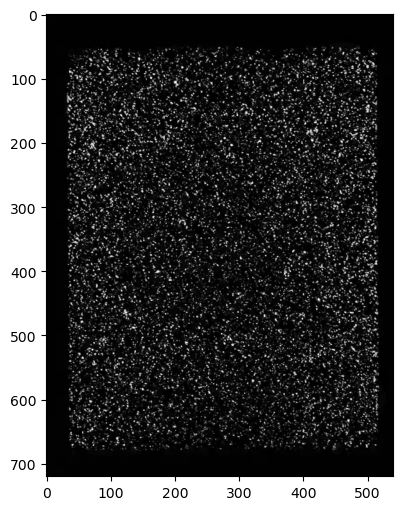

In [6]:
success, image = vidcap.read()
plt.figure(figsize=(6,6))
plt.imshow(image);

Now, we'll create a folder to put our images in and save the first frame using OpenCV's `imwrite` function.

In [7]:
os.mkdir('./ImageFiles')
cv2.imwrite('./ImageFiles/frame00.jpg',image);

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './ImageFiles'

If you check the directory where you started your Jupyter notebook, you should see that you have a new subdirectory called `ImageFiles` with a single <tt>.jpg</tt> file called `frame00.jpg` corresponding to the first frame.

Obviously, reading all our frames in one at a time is tedious, so let's loop the operation. We'll define a variable `counter` to keep track of the frame number and then `while` loop to read in frames and write them out as images until there are no more frames left.

In [8]:
vidcap = cv2.VideoCapture('PIVCleanData.mp4')
success, image = vidcap.read()
counter = 0
while success == True:
    cv2.imwrite('./ImageFiles/frame%02d.jpg' % counter,image);
    success, image = vidcap.read()
    counter = counter + 1

Note that we've exploited Python's string formatting operator `%` to place a new number at the end of each file name. More specifically, the string of characters `%02d` gets replaced by a two digit integer (padded with a zero in the ten's column if it's less than 10) as stored in the variable `counter`. 

<h3>Performing PIV on a pair of images</h3>

Now that we have a set of discrete images, we can go ahead and run the PIV algorithm on them. First, we will import all the relevant libraries from the OpenPIV toolbox, as well as `numpy`.

In [29]:
from openpiv import tools, pyprocess, validation, filters, scaling 

import numpy as np

Next, we'll import the first pair of frames and display them.

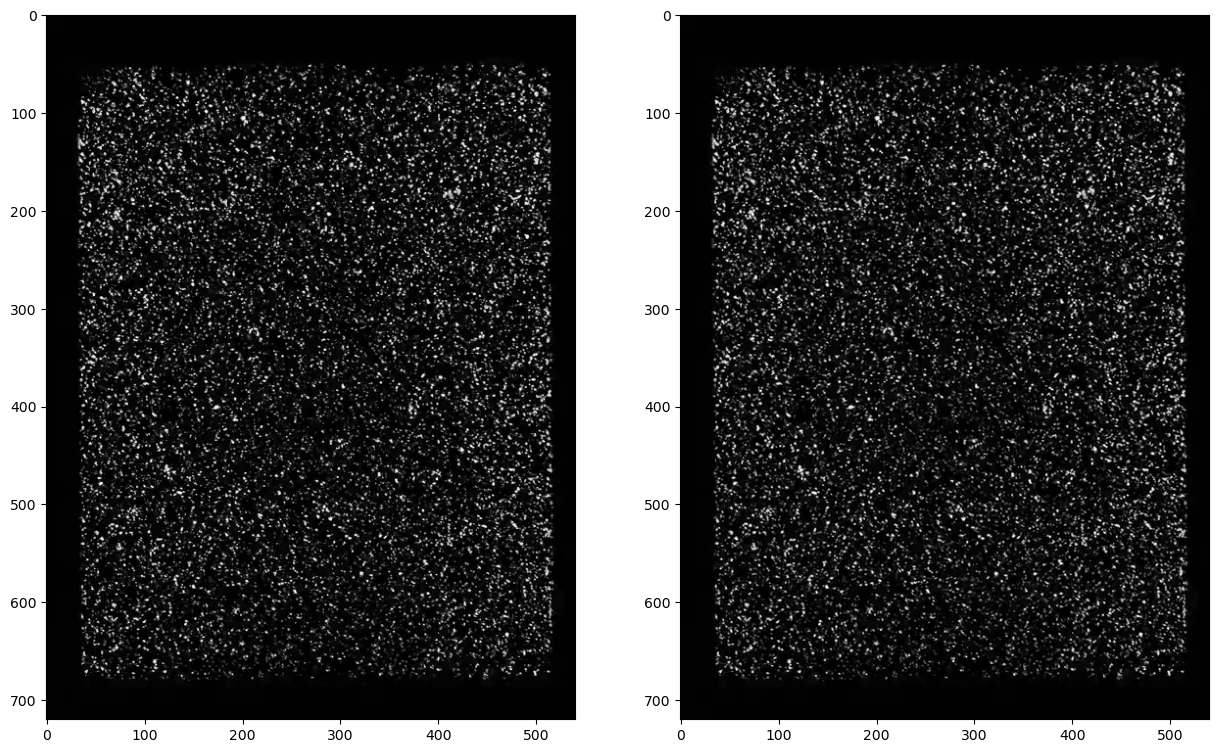

In [10]:
frame_a  = tools.imread( './ImageFiles/frame00.jpg' )
frame_b  = tools.imread( './ImageFiles/frame01.jpg' )
fig,ax = plt.subplots(1,2,figsize=(15,12))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray);


Now, we'll run the actual cross-correlation algorithm. To do so, we'll have to define an interrogation window size `winsize`. The window size will establish the spatial resolution of our measurement (smaller windows give more velocity vectors), but can only be reduced up to a point after which the accuracy of our measurement will be affected. 

To understand why this is the case, think about what would happen if we shrunk our interrogation window size such that there was only one particle in each interrogation window (at least those that had a particle). In that case, each interrogation window will strongly correlate with any surrounding particle and the correlation function will have a bunch of peaks. Thus, it will be impossible to tell what the most probable displacement is since PIV measurements rely on strongly peaked correlation function. 

A common rule of thumb to avoid this is to pick interrogation window sizes so that there around 5 particles in a typical interrogation window. This gives the data in each interrogation window enough "structure" so that it doesn't accidentally correlate well with anything else.

OpenPIV also requires us to set a `searchsize`. This is the size of the interrogation window in the second frame. Typically this is chosen to be about 25% larger than `winsize`. The reason for this is to prevent errors that can arise from particles that leave a given interrogation window between the two frames. 

Finally, we need to set the `overlap` and `dt`. The former sets how much adjacent interrogation windows overlap. This increases our data density (velocity vectors per unit area) but also increases our processing time. Common choices for overlap are between 50-75% of `winsize`. `dt` is the time interval between frames and allows us to convert displacements to velocities. This can be computed from the frame rate at which the video was acquired.

Once we have defined all these parameters, we can run the PIV algorithm by calling the `extended_search_area_piv` function from OpenPIV's `pyprocess` library. This will return the `numpy` arrays `u0` and `v0`, which contain the horizontal and vertical components of the velocity field. It also returns a third `numpy` array called `sig2noise`, which contains an estimate of the signal to noise ratio of each measurement as captured by the ratio of the height of the tallest peak in the correlation function to the height of the second tallest peak. When this is large, the correlation function has a single well-defined peak and we can be more certain that the measurement is correct.

In [11]:
winsize = 16 # pixels, interrogation window size in frame A
searchsize = 20  # pixels, search in frame B
overlap = 12 # pixels, 75% overlap
dt = 0.1 # sec, time interval between frames


u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')

In order to plot our results, we will need to compute the centers of all our interrogation windows. This can be done using the `get_coordinates` function as follows:

In [12]:
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

Once we have our coordinates, we need to rescale everything to physical units since at this point all displacements and interrogation window center coordinates are in pixels. To do this, you can place an object of a known size in the field of view, measuring its size in pixels and then computing the `scaling_factor`, which is the ratio of the size of the object in the image in pixels to the size of the object in physical units. Once you have this number (in our case it is 6.29 px/mm), we can use the `uniform` scaling function from the `scaling` library. Finally, we use the `transform_coordinates` function from the OpenPIV `tools` library to make it so that the origin is at the bottom left corner of our plots instead of the top left as is conventional in computer graphics.

In [13]:
x, y, u0, v0 = scaling.uniform(x, y, u0, v0, scaling_factor = 6.29)

x, y, u0, v0 = tools.transform_coordinates(x, y, u0, v0)

Before we plot our results, you should play the video provided with this notebook (i.e., `PIVCleanData.mp4`) so you can get an idea for what our vector field <i>should</i> look like. You should see that the flow is comprised of alternating bands of upward and downward flow. Let's go ahead and plot our results using `matplotlib`'s `quiver` function.

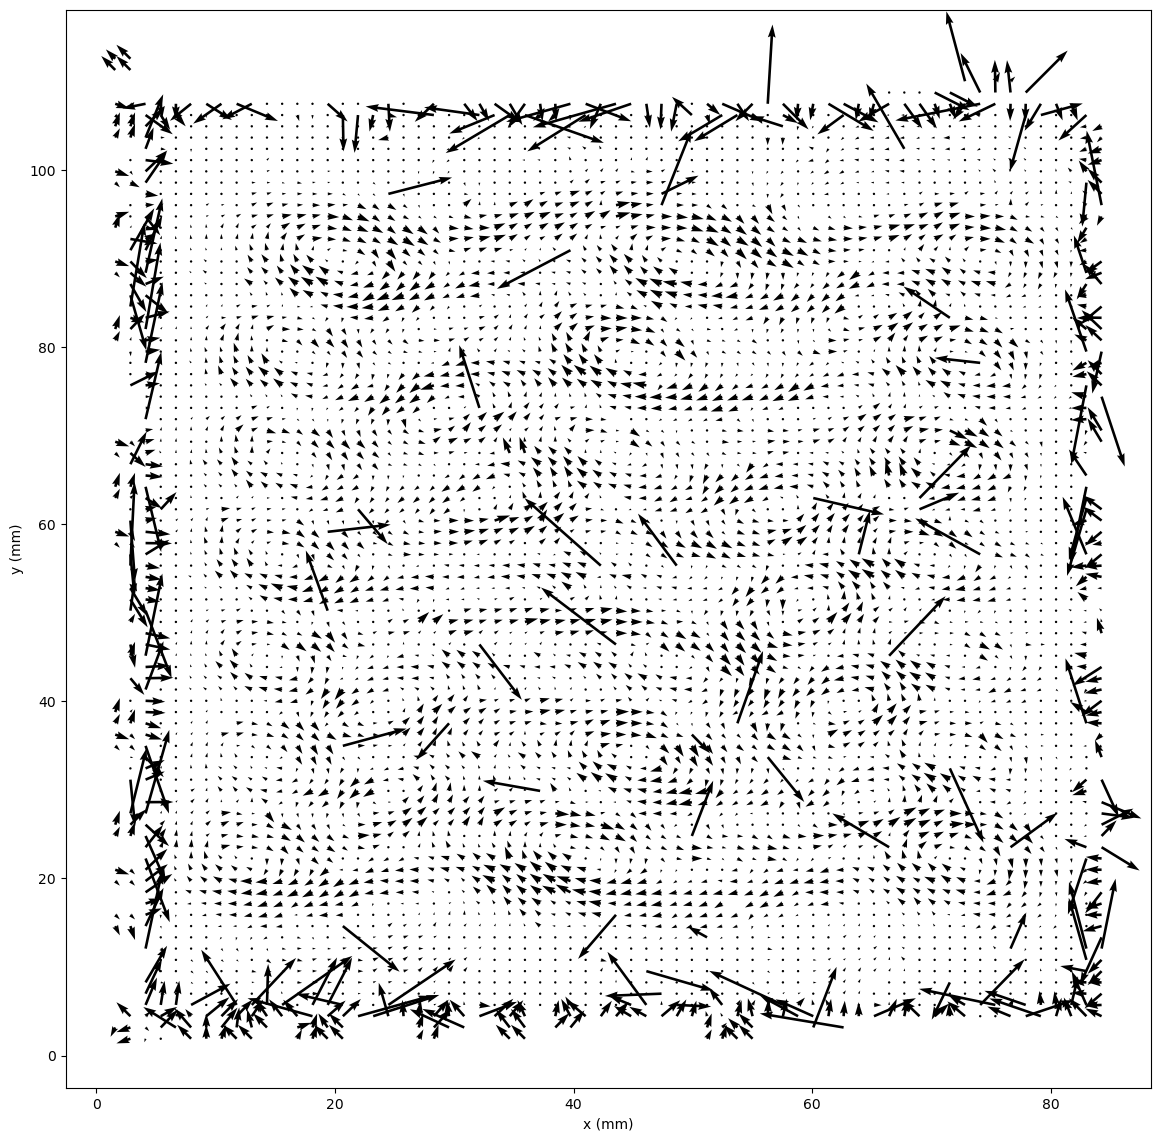

In [14]:
plt.figure(figsize=(14,14))
plt.quiver(x,y,u0,v0)
plt.xlabel('x (mm)')
plt.ylabel('y (mm)');

<h3>Vector Validation</h3>

We can immediately see that there are some issues with our data. For starters, there are some regions where we would expect to see flow but see none (e.g., near the point $(x,y)=(90\,\mathrm{mm},100\,\mathrm{mm})$). If you look carefully at the video, you'll notice that if you look at these regions there are a bunch of particles that are not moving. This is because they have sunk to the bottom of the test section and are stuck there and therefore bias the PIV measurement toward zero. If you have a lot of these regions, you'll want to retake your data and ensure that the majority of your particles are actually floating on the surface of the fluid.

The other issue are the few vectors that seems to be pointing in random directions that don't correspond with our expectations for the flow. These occur when there are some spurious peaks in our correlation function, which can occur when the contrast between the particles and the background is not great or when we have large clumps of particles, which basically correlate with anything. These obvious outliers can be dealt with by applying a variety of filters to throw them out as outliers in a process called vector validation.

The first of these filters is `sig2noise_val`, which uses the signal-to-noise ratio that we computed when we did the cross-correlation above. This simple filter takes any vector whose signal-to-noise ratio (i.e., ratio of the tallest peak in the correlation function to the second tallest peak in the correlation function) is below some `threshold` and replaces it is `NaN`. You'll have to play around with different values of this threshold until you get satisfactory results. Note that if you go too high, you'll throw out the spurious vectors as well as good vectors. We find that for this particular data set, a threshold of about 1.15 works well, although a few pesky outlier remain.

Note: Because of the way OpenPIV's vector validation routines are written, you'll want to use them on a copy of your original vector field. Otherwise, the validation function overwrites your original vector field and you'll have to re-run the cross-correlation step each time you want to try a new threshold.

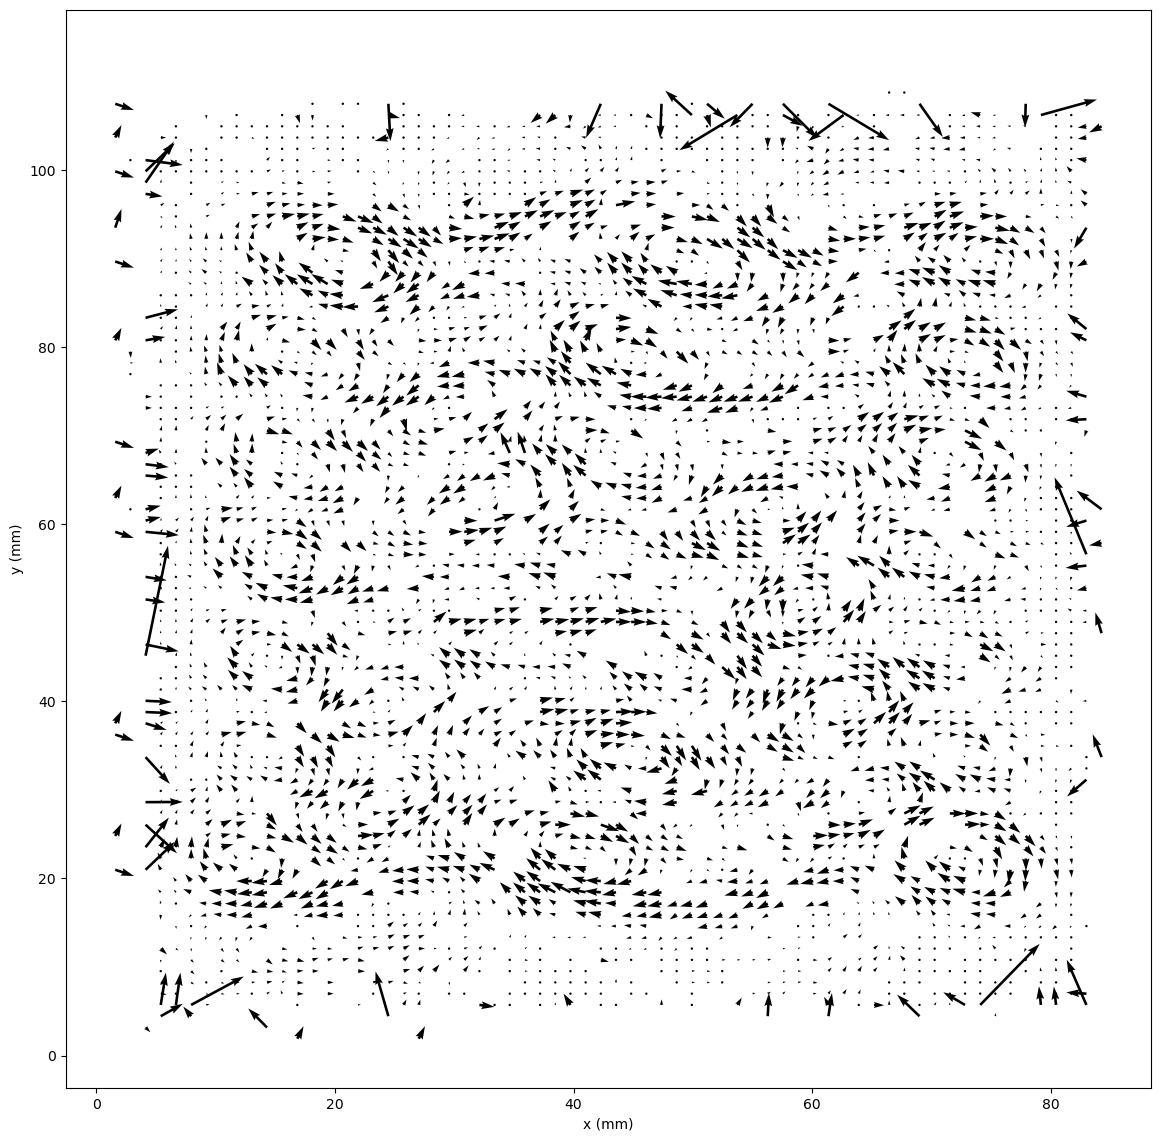

In [23]:
u1 = np.copy(u0)
v1 = np.copy(v0)
u1, v1, mask = validation.sig2noise_val( u1, v1, sig2noise,threshold = 1.5)#original value is 1.15

plt.figure(figsize=(14,14))
plt.quiver(x,y,u1,v1)
plt.xlabel('x (mm)')
plt.ylabel('y (mm)');

In order to deal with the remaining outliers, we can use a global threshold filter. This filter takes any vector whose vector components lie outside of a user specified range. To determine what range to use, we'll look at a histogram of the $x$ and $y$ components of our vector field.

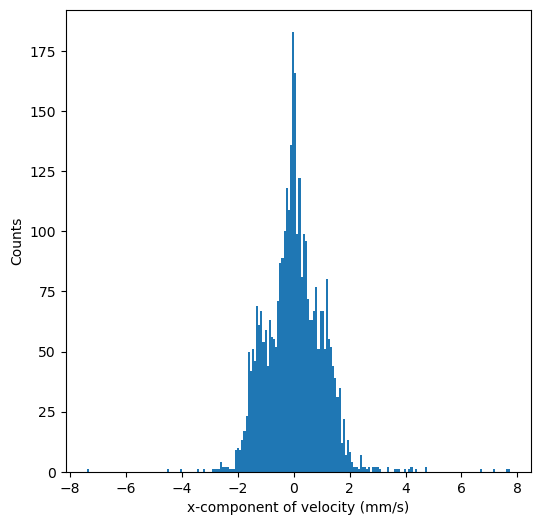

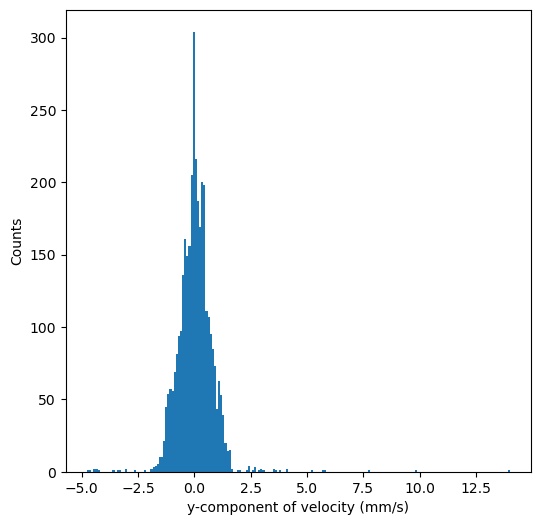

In [28]:
plt.figure(figsize=(6,6))
plt.hist(u1.flatten(),200);
plt.xlabel('x-component of velocity (mm/s)')
plt.ylabel('Counts')

plt.figure(figsize=(6,6))
plt.hist(v1.flatten(),200)
plt.xlabel('y-component of velocity (mm/s)')
plt.ylabel('Counts');

In [31]:
import numpy, warnings
numpy.warnings = warnings

We can see that the vast majority of our data has $x$-components of velocity in the (-3 mm/s, 3 mm/s) range and $y$-components of velocity in the (-7 mm/s, 7 mm/s) range, so we'll use this information along with OpenPIV's `global_val` function to clean up our vector field.

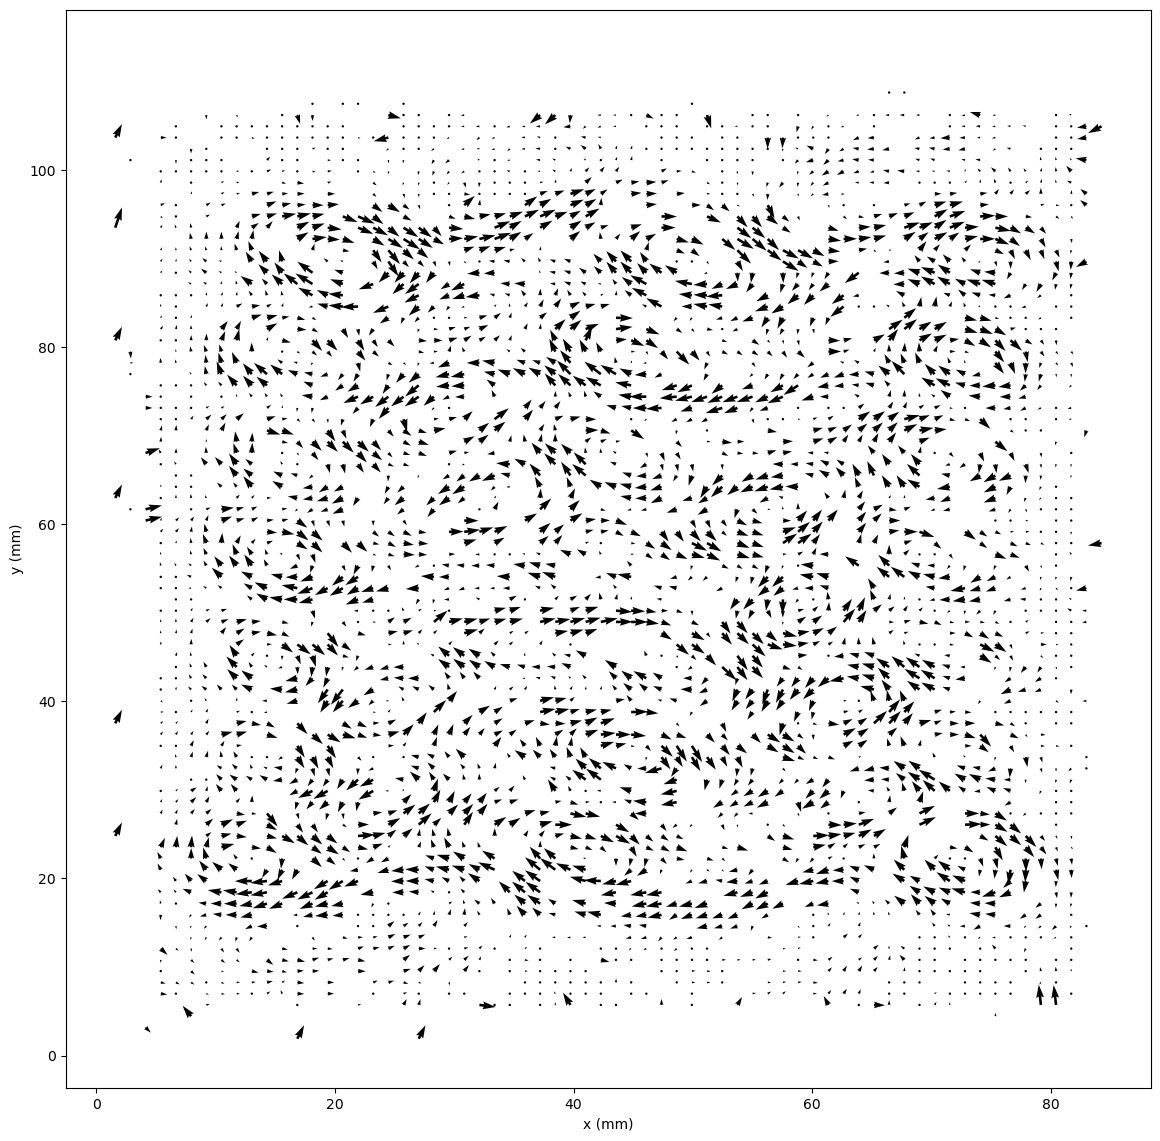

In [34]:
u2 = np.copy(u1)
v2 = np.copy(v1)
urange = (-2,2)
vrange = (-2.5,2.5)
u2, v2, mask = validation.global_val(u2, v2,urange,vrange)

plt.figure(figsize=(14,14))
plt.quiver(x,y,u2,v2)
plt.xlabel('x (mm)')
plt.ylabel('y (mm)');

At this point, our data set is full of holes, which can make it tricky to work with, so it is commmon practice to replace vectors that have been thrown out by interpolating the rest of our data. One common way to do this is to replace a missing vector with the mean of vectors in its neighborhood. We can do this with OpenPIV's `replace_outliers` function, which replaces missing vector iteratively from the outside in, so that if there are adjacent missing vectors, those closest to remaining good vectors get replaced first before attempting to replace vectors "further in". The size of the neighborhood is defined by the parameter `kernel_size` and the total number of iterations used to try to fill in gaps in the data is set by `max_iter`.

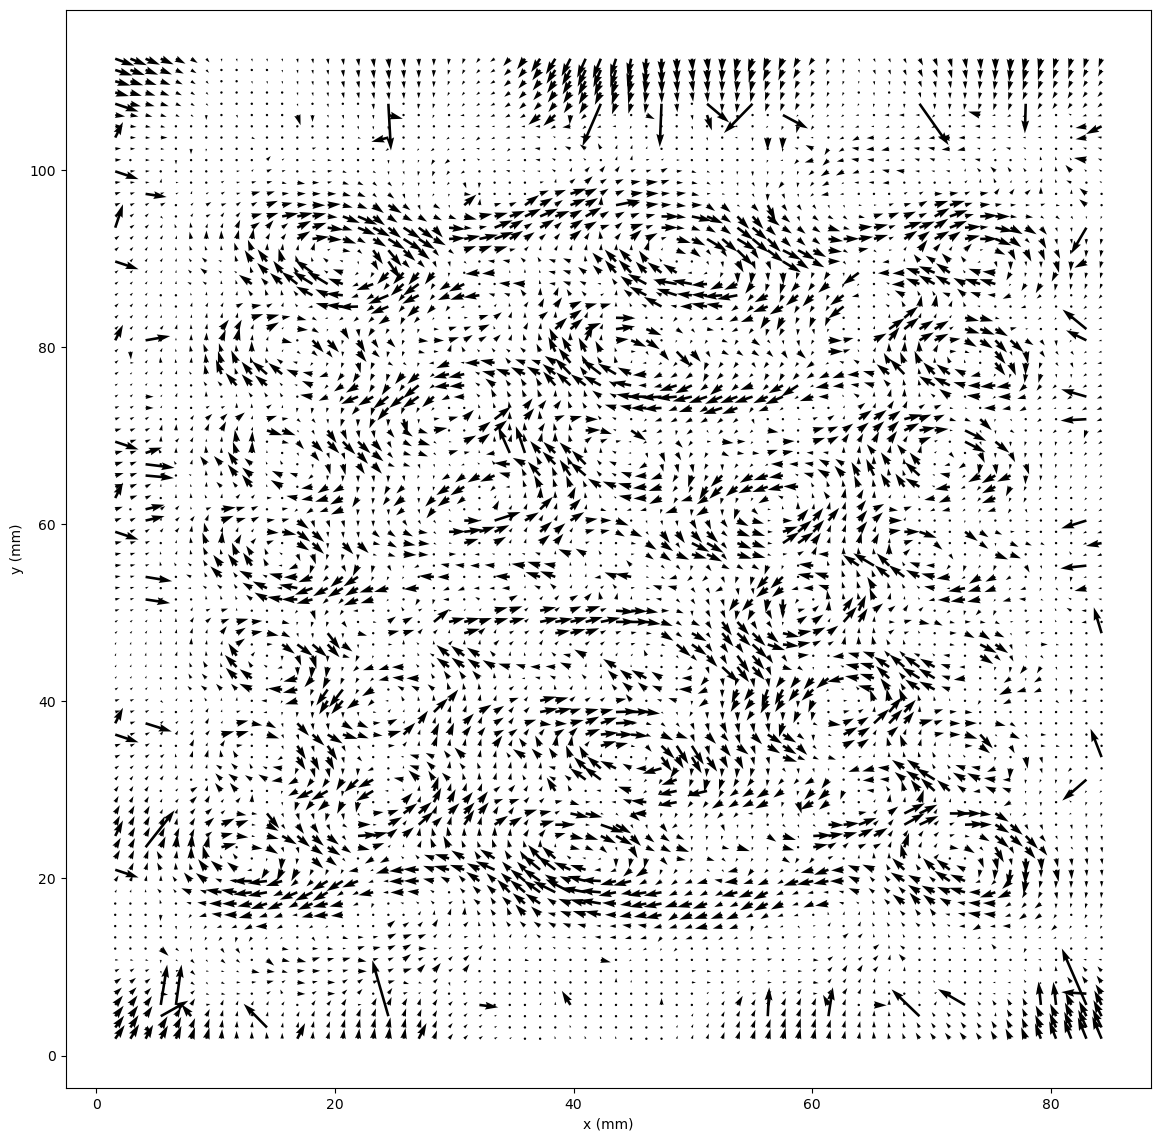

In [33]:
u3 = np.copy(u2)
v3 = np.copy(v2)
u3, v3 = filters.replace_outliers( u2, v2, 
                                  method='localmean', 
                                  max_iter=10, 
                                  kernel_size=3)

plt.figure(figsize=(14,14))
plt.quiver(x,y,u3,v3)
plt.xlabel('x (mm)')
plt.ylabel('y (mm)');

Finally, we can save our data to a text file in case we want to use it for something else later using the `save` function from the `tools` library.

In [35]:
os.mkdir('./VelocityFields')

#save in the simple ASCII table format
tools.save(x, y, u3, v3, mask, './VelocityFields/vel01.txt' )

<h3>Challenge</h3>

Use what you have learned above to compute the Reynolds number for the data in `PIVCleanData.mp4`. As discussed in Kelley, D.H. and Ouellette, N.T., 2011. <i>AJP</i>, <b>79</b>(3), pp.267-273, the Reynolds number for a given data set can be computed by computing the root-mean-square of the magnitude of velocity averaged over all data point in all frames in a time series to get a characteristic velocity for the flow $U$ and then multiplying this by a characteristic lengthscale for the flow $L$ and dividing by the kinematic viscosity of the working fluid $\nu$. For this data set $L=12.7\,\mathrm{mm}$ and $\nu=4.9\,\mathrm{cSt}$ ($1\,\mathrm{cSt} = 1\,\mathrm{mm^2/s}$). The scaling factor for this data set is $3.78\,\mathrm{px/mm}$.